Initialize the environment

In [1]:
from TamGen_Demo import TamGenDemo, prepare_pdb_data
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

worker = TamGenDemo(
    data="./TamGen_Demo_Data",
    ckpt="checkpoints/crossdock_pdb_A10/checkpoint_best.pt",
    use_conditional=True
)

pdb_id = "1HVH"
prepare_pdb_data(pdb_id,)
worker.reload_data(subset="gen_" + pdb_id.lower())

Namespace(no_progress_bar=False, log_interval=1000, log_format=None, tensorboard_logdir='', tbmf_wrapper=False, seed=1, cpu=False, fp16=False, memory_efficient_fp16=False, fp16_init_scale=128, fp16_scale_window=None, fp16_scale_tolerance=0.0, min_loss_scale=0.0001, threshold_loss_scale=None, user_dir=None, criterion='cross_entropy', tokenizer=None, bpe=None, optimizer='nag', lr_scheduler='fixed', task='translation_coord', num_workers=1, skip_invalid_size_inputs_valid_test=False, max_tokens=1024, max_sentences=None, required_batch_size_multiple=8, dataset_impl=None, gen_subset='gen_8fln', num_shards=1, shard_id=0, path='checkpoints/crossdock_pdb_A10/checkpoint_best.pt', remove_bpe=None, quiet=False, model_overrides='{}', results_path=None, beam=20, nbest=20, max_len_a=0, max_len_b=200, min_len=1, match_source_len=False, no_early_stop=False, unnormalized=False, no_beamable_mm=False, lenpen=1, unkpen=0, replace_unk=None, sacrebleu=False, score_reference=False, prefix_size=0, prefix_string

In [2]:
from TamGen_RL import TamGenRL
import torch
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

worker = TamGenRL(
    data="./TamGen_Demo_Data",
    ckpt="checkpoints/crossdocked_model/checkpoint_best.pt",
    use_conditional=True
)

Namespace(no_progress_bar=False, log_interval=1000, log_format=None, tensorboard_logdir='', tbmf_wrapper=False, seed=1, cpu=False, fp16=False, memory_efficient_fp16=False, fp16_init_scale=128, fp16_scale_window=None, fp16_scale_tolerance=0.0, min_loss_scale=0.0001, threshold_loss_scale=None, user_dir=None, criterion='cross_entropy', tokenizer=None, bpe=None, optimizer='nag', lr_scheduler='fixed', task='translation_coord', num_workers=1, skip_invalid_size_inputs_valid_test=False, max_tokens=1024, max_sentences=None, required_batch_size_multiple=8, dataset_impl=None, gen_subset='gen_8fln', num_shards=1, shard_id=0, path='checkpoints/crossdocked_model/checkpoint_best.pt', remove_bpe=None, quiet=False, model_overrides='{}', results_path=None, beam=20, nbest=20, max_len_a=0, max_len_b=200, min_len=1, match_source_len=False, no_early_stop=False, unnormalized=False, no_beamable_mm=False, lenpen=1, unkpen=0, replace_unk=None, sacrebleu=False, score_reference=False, prefix_size=0, prefix_string

2025-06-07 19:08:05,116 [INFO] TamGenRL initialized on device: cuda:0
2025-06-07 19:08:05,117 [INFO] Detected latent dimension: 256


Set the PDB you want to generate cmpds

In [ ]:
worker.reload_data(subset="gen_" + pdb_id.lower())

final_smiles = worker.sample(
    m_sample=10000,      # Tiny
    num_iter=30,      # Just 2 iterations  
    latent_dim=256,
    alpha=0.4,
    top_k=10,
    lambda_sas=0.3,
    lambda_logp=0.1,
    lambda_mw=0.1,
    maxseed=50,       # Just 2 seeds
    use_cuda=torch.cuda.is_available()
)

Visualize

In [ ]:
for i in final_smiles:
    print(i)

In [ ]:
from rdkit import Chem

valid_smiles = []
invalid_smiles = []

for smi in final_smiles:
    mol = Chem.MolFromSmiles(smi)
    if mol:
        valid_smiles.append(smi)
    else:
        invalid_smiles.append(smi)
for i in final_smiles:
    print(i)
print(f"✅ Valid: {len(valid_smiles)}")
print(f"❌ Invalid: {len(invalid_smiles)}")

🔬 REWARD CONVERGENCE ANALYSIS
📊 Found 10 iteration files
   Iter 1: 19 molecules, 1 unique, reward range [-3.104, -3.104]
   Iter 2: 19 molecules, 10 unique, reward range [-3.051, -2.414]
   Iter 3: 19 molecules, 10 unique, reward range [-3.682, -2.461]
   Iter 4: 19 molecules, 9 unique, reward range [-2.925, -2.458]
   Iter 5: 19 molecules, 10 unique, reward range [-2.800, -2.400]
   Iter 6: 19 molecules, 6 unique, reward range [-2.800, -2.461]
   Iter 7: 19 molecules, 10 unique, reward range [-2.800, -2.458]
   Iter 8: 19 molecules, 8 unique, reward range [-2.800, -2.414]
   Iter 9: 19 molecules, 7 unique, reward range [-2.925, -2.458]
   Iter 10: 19 molecules, 12 unique, reward range [-2.800, -2.378]


KeyboardInterrupt: 

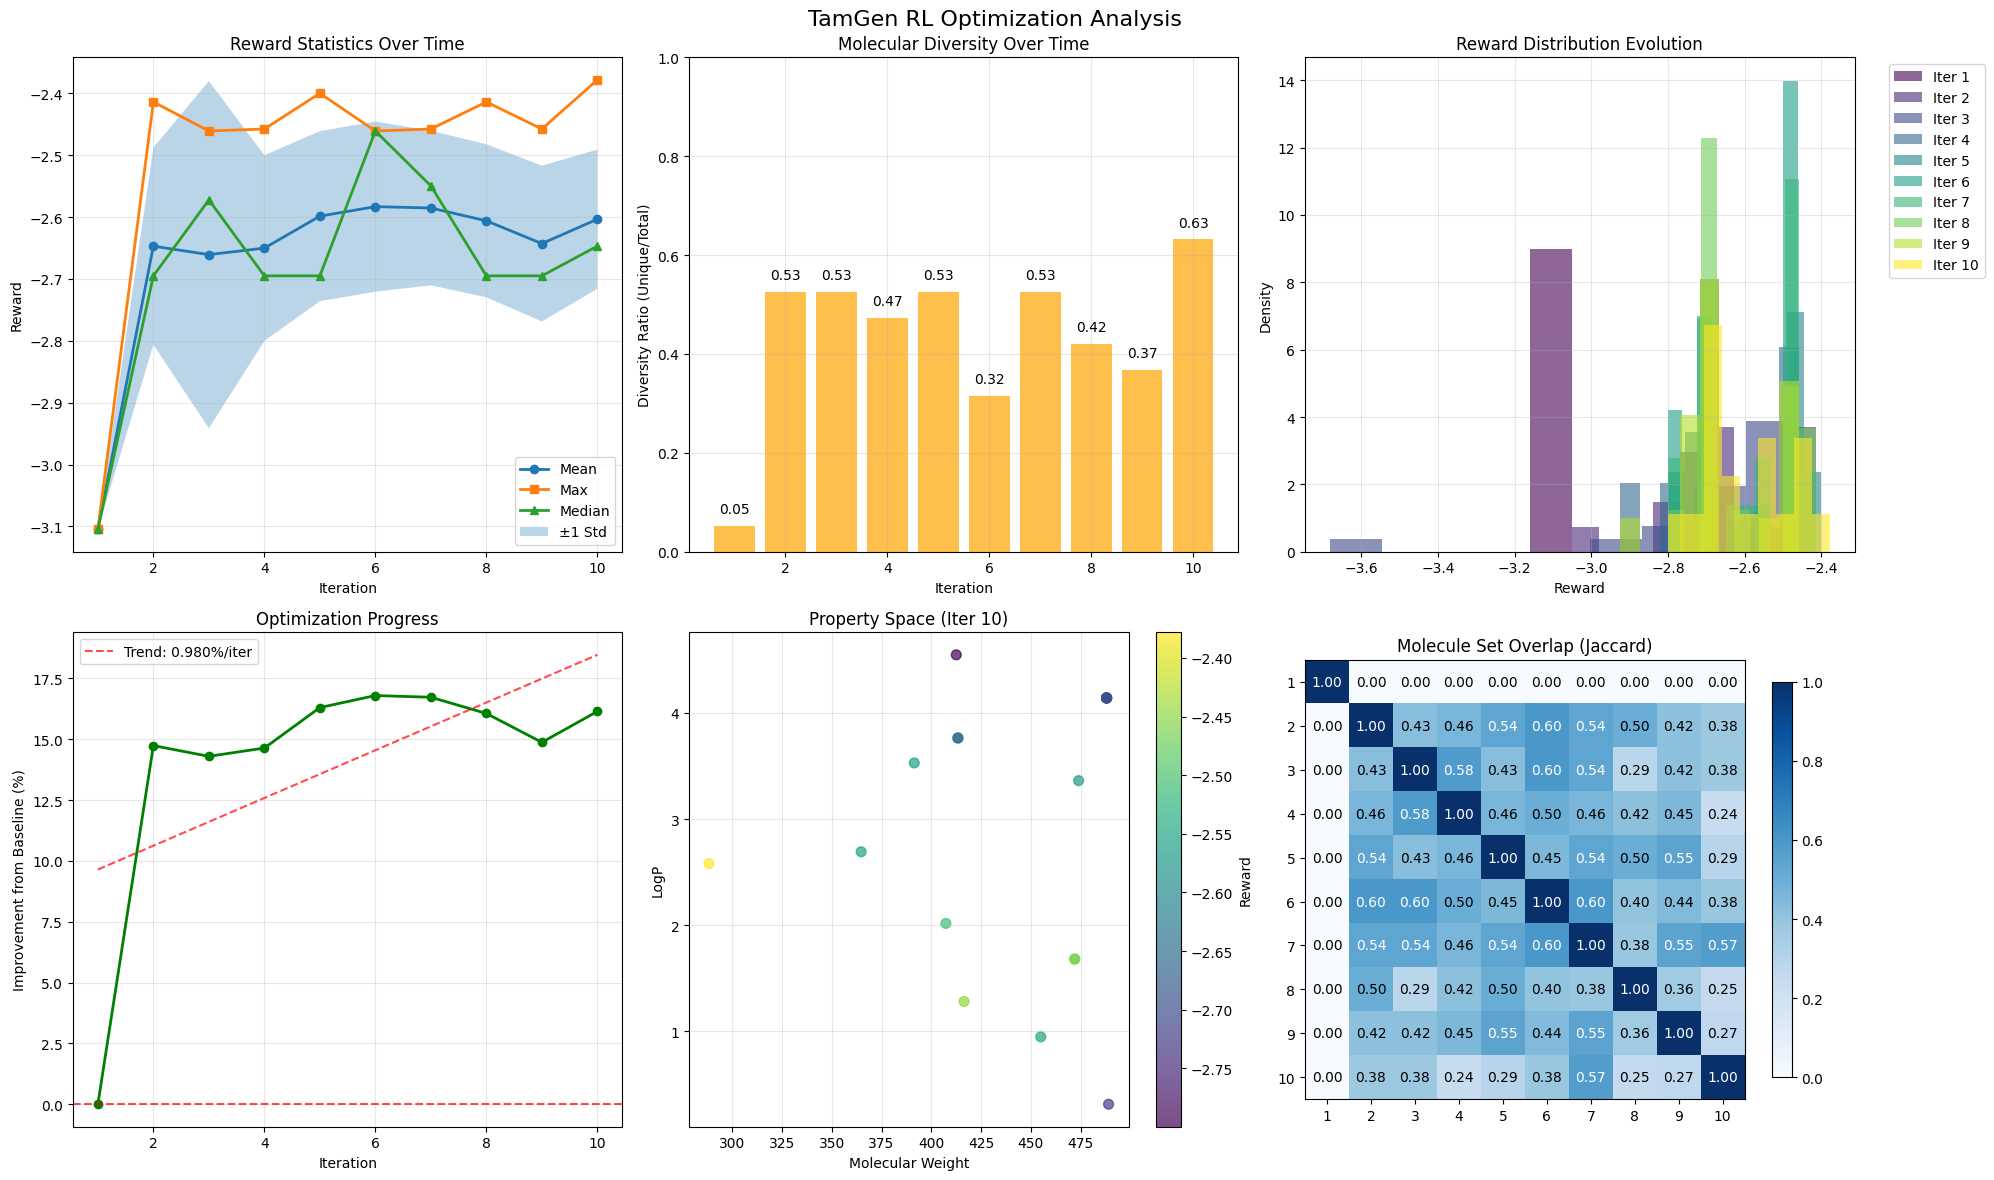

In [4]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

def analyze_reward_convergence():
    """
    Comprehensive analysis of reward function convergence and molecular properties
    """
    
    print("🔬 REWARD CONVERGENCE ANALYSIS")
    print("=" * 60)
    
    # Load reward files
    reward_files = sorted(glob.glob('latent_logs/rewards_iter_*.tsv'))
    if not reward_files:
        print("❌ No reward files found in latent_logs/")
        return
    
    print(f"📊 Found {len(reward_files)} iteration files")
    
    # Parse data with robust error handling
    iteration_data = {}
    all_molecules = set()
    
    for i, f in enumerate(reward_files):
        rewards = []
        molecules = []
        try:
            with open(f, 'r', encoding='utf-8') as fin:
                for line_num, line in enumerate(fin):
                    line = line.strip()
                    if not line:  # Skip empty lines
                        continue
                    parts = line.split('\t')
                    if len(parts) >= 2:
                        mol_smiles = parts[0].strip()
                        try:
                            reward = float(parts[1])
                            # Basic sanity check on reward values
                            if not np.isnan(reward) and not np.isinf(reward):
                                rewards.append(reward)
                                molecules.append(mol_smiles)
                                all_molecules.add(mol_smiles)
                        except (ValueError, TypeError):
                            print(f"   ⚠️ Warning: Invalid reward value at line {line_num+1} in {f}")
                            continue
        except Exception as e:
            print(f"   ❌ Error reading {f}: {e}")
            continue
        
        if rewards:  # Only add if we have valid data
            iteration_data[i+1] = {
                'rewards': np.array(rewards),
                'molecules': molecules,
                'mean': np.mean(rewards),
                'max': np.max(rewards),
                'median': np.median(rewards),
                'std': np.std(rewards),
                'unique_count': len(set(molecules))
            }
            
            print(f"   Iter {i+1}: {len(rewards)} molecules, {len(set(molecules))} unique, "
                  f"reward range [{np.min(rewards):.3f}, {np.max(rewards):.3f}]")
        else:
            print(f"   ❌ No valid data in {f}")
    
    if not iteration_data:
        print("❌ No valid iteration data found!")
        return None
    
    # Create comprehensive plots
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle('TamGen RL Optimization Analysis', fontsize=16)
    
    iterations = sorted(list(iteration_data.keys()))
    n_iterations = len(iterations)
    
    # 1. Reward Statistics Over Time
    ax1 = axes[0, 0]
    means = [iteration_data[i]['mean'] for i in iterations]
    maxs = [iteration_data[i]['max'] for i in iterations]
    medians = [iteration_data[i]['median'] for i in iterations]
    stds = [iteration_data[i]['std'] for i in iterations]
    
    ax1.plot(iterations, means, 'o-', label='Mean', linewidth=2)
    ax1.plot(iterations, maxs, 's-', label='Max', linewidth=2)
    ax1.plot(iterations, medians, '^-', label='Median', linewidth=2)
    ax1.fill_between(iterations, 
                     [m - s for m, s in zip(means, stds)],
                     [m + s for m, s in zip(means, stds)],
                     alpha=0.3, label='±1 Std')
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Reward')
    ax1.set_title('Reward Statistics Over Time')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Diversity Analysis
    ax2 = axes[0, 1]
    total_counts = [len(iteration_data[i]['molecules']) for i in iterations]
    unique_counts = [iteration_data[i]['unique_count'] for i in iterations]
    diversity_ratios = [u/t for u, t in zip(unique_counts, total_counts)]
    
    ax2.bar(iterations, diversity_ratios, alpha=0.7, color='orange')
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('Diversity Ratio (Unique/Total)')
    ax2.set_title('Molecular Diversity Over Time')
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(0, 1)
    
    # Add text annotations
    for i, ratio in zip(iterations, diversity_ratios):
        ax2.text(i, ratio + 0.02, f'{ratio:.2f}', ha='center', va='bottom')
    
    # 3. Reward Distribution Evolution (sample for high iteration counts)
    ax3 = axes[0, 2]
    # For many iterations, only show a subset to avoid cluttered plot
    if n_iterations > 10:
        step = max(1, n_iterations // 8)  # Show max 8 distributions
        sample_iterations = iterations[::step]
        colors = plt.cm.viridis(np.linspace(0, 1, len(sample_iterations)))
        for iter_idx, color in zip(sample_iterations, colors):
            rewards = iteration_data[iter_idx]['rewards']
            ax3.hist(rewards, bins=min(20, len(rewards)//2), alpha=0.6, 
                    label=f'Iter {iter_idx}', color=color, density=True)
        ax3.set_title(f'Reward Distribution Evolution (sampled)')
    else:
        colors = plt.cm.viridis(np.linspace(0, 1, len(iterations)))
        for i, color in zip(iterations, colors):
            rewards = iteration_data[i]['rewards']
            ax3.hist(rewards, bins=min(20, len(rewards)//2), alpha=0.6, 
                    label=f'Iter {i}', color=color, density=True)
        ax3.set_title('Reward Distribution Evolution')
    
    ax3.set_xlabel('Reward')
    ax3.set_ylabel('Density')
    ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax3.grid(True, alpha=0.3)
    
    # 4. Convergence Analysis
    ax4 = axes[1, 0]
    # Calculate running improvement
    improvements = []
    base_mean = means[0]
    for mean in means:
        improvements.append((mean - base_mean) / abs(base_mean) * 100)
    
    ax4.plot(iterations, improvements, 'o-', linewidth=2, color='green')
    ax4.axhline(y=0, color='red', linestyle='--', alpha=0.7)
    ax4.set_xlabel('Iteration')
    ax4.set_ylabel('Improvement from Baseline (%)')
    ax4.set_title('Optimization Progress')
    ax4.grid(True, alpha=0.3)
    
    # Add trend line
    if len(iterations) > 2:
        try:
            z = np.polyfit(iterations, improvements, 1)
            p = np.poly1d(z)
            ax4.plot(iterations, p(iterations), '--', alpha=0.7, color='red',
                    label=f'Trend: {z[0]:.3f}%/iter')
            ax4.legend()
        except np.RankWarning:
            pass  # Skip trend line if fitting fails
    
    # 5. Molecular Property Analysis (if we can parse SMILES)
    ax5 = axes[1, 1]
    try:
        # Analyze molecular properties for last iteration
        last_iter = max(iterations)
        last_molecules = iteration_data[last_iter]['molecules']
        last_rewards = iteration_data[last_iter]['rewards']
        
        # Calculate molecular properties
        mw_values = []
        logp_values = []
        valid_rewards = []
        
        for mol_smiles, reward in zip(last_molecules, last_rewards):
            mol = Chem.MolFromSmiles(mol_smiles)
            if mol is not None:
                mw = Descriptors.MolWt(mol)
                logp = Descriptors.MolLogP(mol)
                mw_values.append(mw)
                logp_values.append(logp)
                valid_rewards.append(reward)
        
        if mw_values:
            scatter = ax5.scatter(mw_values, logp_values, c=valid_rewards, 
                                cmap='viridis', alpha=0.7, s=50)
            ax5.set_xlabel('Molecular Weight')
            ax5.set_ylabel('LogP')
            ax5.set_title(f'Property Space (Iter {last_iter})')
            plt.colorbar(scatter, ax=ax5, label='Reward')
            ax5.grid(True, alpha=0.3)
        else:
            ax5.text(0.5, 0.5, 'No valid molecules\nfor property analysis', 
                    ha='center', va='center', transform=ax5.transAxes)
            ax5.set_title('Property Analysis Failed')
    
    except Exception as e:
        ax5.text(0.5, 0.5, f'Property analysis failed:\n{str(e)}', 
                ha='center', va='center', transform=ax5.transAxes)
        ax5.set_title('Property Analysis Error')
    
    # 6. Molecule Overlap Analysis (optimize for many iterations)
    ax6 = axes[1, 2]
    if len(iterations) > 1:
        # For many iterations, sample to keep matrix readable
        if n_iterations > 15:
            step = max(1, n_iterations // 10)  # Show max 10x10 matrix
            sample_iters = iterations[::step]
            overlap_matrix = np.zeros((len(sample_iters), len(sample_iters)))
            for i, iter1 in enumerate(sample_iters):
                for j, iter2 in enumerate(sample_iters):
                    set1 = set(iteration_data[iter1]['molecules'])
                    set2 = set(iteration_data[iter2]['molecules'])
                    if len(set1.union(set2)) > 0:
                        overlap = len(set1.intersection(set2)) / len(set1.union(set2))
                    else:
                        overlap = 0
                    overlap_matrix[i, j] = overlap
            
            im = ax6.imshow(overlap_matrix, cmap='Blues', vmin=0, vmax=1)
            ax6.set_xticks(range(len(sample_iters)))
            ax6.set_yticks(range(len(sample_iters)))
            ax6.set_xticklabels([f'{i}' for i in sample_iters], rotation=45)
            ax6.set_yticklabels([f'{i}' for i in sample_iters])
            ax6.set_title(f'Molecule Overlap (sampled)')
        else:
            overlap_matrix = np.zeros((len(iterations), len(iterations)))
            for i, iter1 in enumerate(iterations):
                for j, iter2 in enumerate(iterations):
                    set1 = set(iteration_data[iter1]['molecules'])
                    set2 = set(iteration_data[iter2]['molecules'])
                    if len(set1.union(set2)) > 0:
                        overlap = len(set1.intersection(set2)) / len(set1.union(set2))
                    else:
                        overlap = 0
                    overlap_matrix[i, j] = overlap
            
            im = ax6.imshow(overlap_matrix, cmap='Blues', vmin=0, vmax=1)
            ax6.set_xticks(range(len(iterations)))
            ax6.set_yticks(range(len(iterations)))
            ax6.set_xticklabels([f'{i}' for i in iterations])
            ax6.set_yticklabels([f'{i}' for i in iterations])
            ax6.set_title('Molecule Set Overlap (Jaccard)')
            
            # Add text annotations only for smaller matrices
            if len(iterations) <= 10:
                for i in range(len(iterations)):
                    for j in range(len(iterations)):
                        ax6.text(j, i, f'{overlap_matrix[i, j]:.2f}',
                                ha='center', va='center', 
                                color='white' if overlap_matrix[i, j] > 0.5 else 'black')
        
        plt.colorbar(im, ax=ax6, shrink=0.8)
    else:
        ax6.text(0.5, 0.5, 'Need multiple iterations\nfor overlap analysis', 
                ha='center', va='center', transform=ax6.transAxes)
        ax6.set_title('Molecule Overlap Analysis')
    
    plt.tight_layout()
    
    # Save plot with error handling
    try:
        plt.savefig('latent_logs/reward_analysis.png', dpi=300, bbox_inches='tight')
        print("📊 Analysis plot saved to 'latent_logs/reward_analysis.png'")
    except Exception as e:
        print(f"⚠️ Could not save plot: {e}")
    
    plt.show()
    
    # Print detailed analysis
    print("\n📈 DETAILED ANALYSIS")
    print("=" * 60)
    
    # Convergence assessment with robust statistics
    if len(iterations) >= 3:
        recent_window = min(5, len(iterations))  # Use last 5 iterations or all if fewer
        recent_means = means[-recent_window:]
        mean_change = np.std(recent_means)
        if mean_change < 0.01:
            print("🔄 CONVERGENCE: Mean rewards have stabilized (std < 0.01)")
        else:
            print(f"📈 TRENDING: Mean rewards still changing (std = {mean_change:.3f})")
        
        # Check for improvement
        total_improvement = (means[-1] - means[0]) / abs(means[0]) * 100
        print(f"📊 OVERALL IMPROVEMENT: {total_improvement:+.1f}% from baseline")
        
        # Best molecules
        try:
            best_iter = max(iterations, key=lambda x: iteration_data[x]['max'])
            best_reward = iteration_data[best_iter]['max']
            best_idx = np.argmax(iteration_data[best_iter]['rewards'])
            best_molecule = iteration_data[best_iter]['molecules'][best_idx]
            
            print(f"🏆 BEST MOLECULE: {best_molecule}")
            print(f"   Reward: {best_reward:.3f} (Iteration {best_iter})")
        except Exception as e:
            print(f"⚠️ Could not identify best molecule: {e}")
        
        # Diversity trend
        try:
            diversity_trend = np.polyfit(iterations, diversity_ratios, 1)[0]
            if diversity_trend < -0.01:
                print(f"⚠️ DIVERSITY DECLINING: {diversity_trend:.3f}/iteration")
            elif diversity_trend > 0.01:
                print(f"✅ DIVERSITY IMPROVING: {diversity_trend:.3f}/iteration")
            else:
                print(f"➡️ DIVERSITY STABLE: {diversity_trend:.3f}/iteration")
        except Exception:
            print("⚠️ Could not calculate diversity trend")
    
    # Recommendations with robust checks
    print("\n💡 RECOMMENDATIONS")
    print("=" * 30)
    
    latest_diversity = diversity_ratios[-1] if diversity_ratios else 0
    if latest_diversity < 0.1:
        print("🔧 INCREASE EXPLORATION: Very low diversity detected")
        print("   - Increase noise_sigma (try 0.1-0.2)")
        print("   - Reduce shift_alpha (try 0.2-0.3)")
        print("   - Add diversity penalty to reward function")
    
    if len(iterations) >= 3:
        try:
            recent_improvement = (means[-1] - means[-3]) / abs(means[-3]) * 100
            if abs(recent_improvement) < 1:
                print("🔄 CONSIDER STOPPING: Minimal recent improvement")
                print("   - Try different hyperparameters")
                print("   - Or accept current results")
            elif recent_improvement > 0:
                print("✅ CONTINUE OPTIMIZATION: Still improving")
            else:
                print("📉 OPTIMIZATION ISSUES: Performance declining")
        except Exception:
            print("⚠️ Could not assess recent improvement")
    
    # Additional insights for long runs
    if len(iterations) >= 10:
        print(f"\n🔍 LONG RUN INSIGHTS:")
        print(f"   - Total iterations analyzed: {len(iterations)}")
        print(f"   - Total unique molecules discovered: {len(all_molecules)}")
        
        # Check for plateaus
        if len(means) >= 10:
            last_10_improvement = (means[-1] - means[-10]) / abs(means[-10]) * 100
            print(f"   - Improvement over last 10 iterations: {last_10_improvement:+.1f}%")
            
        # Memory usage estimate
        total_molecules = sum(len(iteration_data[i]['molecules']) for i in iterations)
        print(f"   - Total molecules evaluated: {total_molecules}")
    
    print(f"\n📋 SUMMARY STATISTICS")
    print(f"   Best reward found: {max(maxs):.3f}")
    print(f"   Final mean reward: {means[-1]:.3f}")
    print(f"   Current diversity: {latest_diversity:.1%}")
    print(f"   Iterations completed: {len(iterations)}")
    
    return iteration_data

if __name__ == "__main__":
    result = analyze_reward_convergence()
    if result is not None:
        print("✅ Analysis completed successfully!")
    else:
        print("❌ Analysis failed - check your data files!")

In [ ]:
import optuna
import torch
import logging
from check import summarize  # your validation module

# Setup logging
logging.basicConfig(
    filename="optuna_trials_v2.log",
    level=logging.INFO,
    format="%(asctime)s [Trial %(levelname)s] %(message)s",
    filemode='w'  # overwrite each time
)

def make_objective(worker, pdb_id):
    def objective(trial):
        # Suggested hyperparameters
        lambda_logp = trial.suggest_float("lambda_logp", 0.05, 0.5)
        lambda_mw   = trial.suggest_float("lambda_mw", 0.05, 0.5)
        alpha       = trial.suggest_float("alpha", 0.1, 0.6)
        top_k       = trial.suggest_categorical("top_k", [10, 20, 50, 100])
        docking_weight = trial.suggest_float("docking_weight", 1.0, 4.0)
        diversity_weight = trial.suggest_float("diversity_weight", 0.1, 1.0)

        # Fixed params
        lambda_sas = 1.5
        latent_dim = 256
        maxseed    = 20
        m_sample   = 1000
        num_iter   = 10

        try:
            # Load data for current PDB
            worker.reload_data(subset="gen_" + pdb_id.lower())

            # Run sampling optimization
            final_smiles = worker.sample(
                m_sample=m_sample,
                num_iter=num_iter,
                latent_dim=latent_dim,
                alpha=alpha,
                top_k=top_k,
                lambda_sas=lambda_sas,
                lambda_logp=lambda_logp,
                lambda_mw=lambda_mw,
                maxseed=maxseed,
                use_cuda=torch.cuda.is_available(),
                docking_weight=docking_weight,
                diversity_weight=diversity_weight
            )

            # Evaluate results
            result = summarize(final_smiles)
            mean_qed = result["mean_qed"]
            mean_logp = result["mean_logp"]
            diversity = result["diversity_mean"]
            validity_pct = result["validity_pct"]

            # Log this trial
            logging.info(
                f"Trial {trial.number}: QED={mean_qed:.4f}, LogP={mean_logp:.2f}, Diversity={diversity:.4f}, "
                f"Validity={validity_pct:.1f}%, alpha={alpha}, top_k={top_k}, lambda_logp={lambda_logp}, "
           ``     f"lambda_mw={lambda_mw}, docking_weight={docking_weight}, diversity_weight={diversity_weight}"
            )

            # Return QED as optimization target (can change this)
            return mean_qed

        except Exception as e:
            logging.error(f"Trial {trial.number} failed: {str(e)}")
            return 0.0  # Return worst-case score on error
    return objective


In [6]:
# Assume worker is already instantiated, and pdb_id is a string
objective = make_objective(worker, pdb_id=pdb_id)  # Change as needed

# Create Optuna study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

# Print best results
print("Best hyperparameters:", study.best_params)
print("Best QED score:", study.best_value)

[I 2025-06-07 19:08:25,713] A new study created in memory with name: no-name-eeeeb227-5e63-46af-b52b-216073a66688
2025-06-07 19:08:25,723 [INFO] 🚀 Starting TamGenRL feedback loop optimization
2025-06-07 19:08:25,724 [INFO]    Target: 1000 molecules × 10 iterations
2025-06-07 19:08:25,725 [INFO]    Device: cuda:0, Batch size: 4
2025-06-07 19:08:25,727 [INFO] 
🔄 Iteration 1/10 (α=0.256)
2025-06-07 19:08:25,728 [INFO] 🌱 Generating initial molecules with TamGen...


| loaded 1 examples from: ./TamGen_Demo_Data/gen_1hvh.tg-m1.tg
| loaded 1 examples from: ./TamGen_Demo_Data/gen_1hvh.tg-m1.m1
| ./TamGen_Demo_Data gen_1hvh tg-m1 1 examples
| loaded 1 examples from: ./TamGen_Demo_Data/gen_1hvh.tg-m1.tg.coord


Initial generation:   2%|▏         | 20/1000 [00:28<23:07,  1.42s/it]
2025-06-07 19:08:54,046 [INFO]    ✓ Generated 20 initial molecules
2025-06-07 19:08:54,047 [INFO]    ✓ Diversity: 5/20 (25.00%)
2025-06-07 19:08:54,048 [WARNING] Low diversity detected (25.00% < 70.00%)
2025-06-07 19:08:54,049 [INFO] 📊 Optimizing latent space...


🧠 Starting centroid shift optimization for 20 samples
   Using top-20 samples for optimization
[INFO] LatentRewardModel initialized on device: cuda
📊 Computing molecular rewards...
   ✓ Computed rewards for 20/20 valid molecules
🎯 Training reward model...
[INFO] Training complete. Final train loss: 0.8683
   ✓ Training complete: 50 epochs, final loss: 0.8683
🧭 Computing optimal shift direction...


2025-06-07 19:08:56,125 [INFO]    ✓ Saved results for iteration 1
2025-06-07 19:08:56,126 [INFO]    ✓ Generated 20 molecules
2025-06-07 19:08:56,127 [INFO]    ✓ Diversity: 5/20 (25.00%)
2025-06-07 19:08:56,129 [INFO]    ✓ Reward: μ=2.057, σ=0.570, max=2.769
2025-06-07 19:08:56,130 [INFO]    ✓ Time: 30.4s
2025-06-07 19:08:56,131 [INFO] 
🔄 Iteration 2/10 (α=0.236)
2025-06-07 19:08:56,133 [INFO] 🔄 Generating from 20 latent vectors...


   ✓ gradient-based optimization complete, direction norm: 5.8349
🔄 Applying latent space shifts...
📈 Optimization summary:
   • Reward distribution: μ=2.057, σ=0.570
   • Valid molecules: 20/20
   • Shift magnitude: 5.8349
   • Applied noise: σ=0.1000
   ⚠️  Low diversity detected: 5/20 unique SMILES
      Consider increasing noise_sigma or reducing shift_alpha
[INFO] Cleared stored latent vectors and rewards.
✅ Centroid shift optimization complete: 20 shifted vectors


2025-06-07 19:09:02,418 [INFO]    ✓ Generated 20/20 valid SMILES
2025-06-07 19:09:02,421 [INFO] 📊 Optimizing latent space...


🧠 Starting centroid shift optimization for 20 samples
   Using top-20 samples for optimization
[INFO] LatentRewardModel initialized on device: cuda
📊 Computing molecular rewards...
   ✓ Computed rewards for 20/20 valid molecules
🎯 Training reward model...
[INFO] Training complete. Final train loss: 0.0063
   ✓ Training complete: 60 epochs, final loss: 0.0063
🧭 Computing optimal shift direction...


2025-06-07 19:09:03,626 [INFO]    ✓ Saved results for iteration 2
2025-06-07 19:09:03,627 [INFO]    ✓ Generated 20 molecules
2025-06-07 19:09:03,628 [INFO]    ✓ Diversity: 10/20 (50.00%)
2025-06-07 19:09:03,630 [INFO]    ✓ Reward: μ=2.295, σ=0.962, max=3.484
2025-06-07 19:09:03,631 [INFO]    ✓ Time: 7.5s
2025-06-07 19:09:03,632 [INFO] 
🔄 Iteration 3/10 (α=0.216)
2025-06-07 19:09:03,634 [INFO] 🔄 Generating from 20 latent vectors...


   ✓ gradient-based optimization complete, direction norm: 5.8295
🔄 Applying latent space shifts...
📈 Optimization summary:
   • Reward distribution: μ=2.295, σ=0.962
   • Valid molecules: 20/20
   • Shift magnitude: 5.8295
   • Applied noise: σ=0.0950
   ✓ Good diversity: 10/20 unique SMILES
[INFO] Cleared stored latent vectors and rewards.
✅ Centroid shift optimization complete: 20 shifted vectors


2025-06-07 19:09:10,073 [INFO]    ✓ Generated 20/20 valid SMILES
2025-06-07 19:09:10,074 [INFO] 📊 Optimizing latent space...


🧠 Starting centroid shift optimization for 20 samples
   Using top-20 samples for optimization
[INFO] LatentRewardModel initialized on device: cuda
📊 Computing molecular rewards...
   ✓ Computed rewards for 20/20 valid molecules
🎯 Training reward model...
[INFO] Training complete. Final train loss: 0.0312
   ✓ Training complete: 70 epochs, final loss: 0.0312
🧭 Computing optimal shift direction...


2025-06-07 19:09:11,716 [INFO]    ✓ Saved results for iteration 3
2025-06-07 19:09:11,717 [INFO]    ✓ Generated 20 molecules
2025-06-07 19:09:11,719 [INFO]    ✓ Diversity: 12/20 (60.00%)
2025-06-07 19:09:11,720 [INFO]    ✓ Reward: μ=2.608, σ=0.696, max=3.484
2025-06-07 19:09:11,722 [INFO]    ✓ Time: 8.1s
2025-06-07 19:09:11,723 [INFO] 
🔄 Iteration 4/10 (α=0.196)
2025-06-07 19:09:11,724 [INFO] 🔄 Generating from 20 latent vectors...


   ✓ gradient-based optimization complete, direction norm: 5.4801
🔄 Applying latent space shifts...
📈 Optimization summary:
   • Reward distribution: μ=2.608, σ=0.696
   • Valid molecules: 20/20
   • Shift magnitude: 5.4801
   • Applied noise: σ=0.0900
   ✓ Good diversity: 12/20 unique SMILES
[INFO] Cleared stored latent vectors and rewards.
✅ Centroid shift optimization complete: 20 shifted vectors


2025-06-07 19:09:18,163 [INFO]    ✓ Generated 20/20 valid SMILES
2025-06-07 19:09:18,166 [INFO] 📊 Optimizing latent space...


🧠 Starting centroid shift optimization for 20 samples
   Using top-20 samples for optimization
[INFO] LatentRewardModel initialized on device: cuda
📊 Computing molecular rewards...
   ✓ Computed rewards for 20/20 valid molecules
🎯 Training reward model...
[INFO] Training complete. Final train loss: 0.0082
   ✓ Training complete: 80 epochs, final loss: 0.0082
🧭 Computing optimal shift direction...


2025-06-07 19:09:19,648 [INFO]    ✓ Saved results for iteration 4
2025-06-07 19:09:19,649 [INFO]    ✓ Generated 20 molecules
2025-06-07 19:09:19,650 [INFO]    ✓ Diversity: 10/20 (50.00%)
2025-06-07 19:09:19,653 [INFO]    ✓ Reward: μ=2.879, σ=0.572, max=3.334
2025-06-07 19:09:19,654 [INFO]    ✓ Time: 7.9s
2025-06-07 19:09:19,655 [INFO] 
🔄 Iteration 5/10 (α=0.176)
2025-06-07 19:09:19,657 [INFO] 🔄 Generating from 20 latent vectors...


   ✓ gradient-based optimization complete, direction norm: 5.1915
🔄 Applying latent space shifts...
📈 Optimization summary:
   • Reward distribution: μ=2.879, σ=0.572
   • Valid molecules: 20/20
   • Shift magnitude: 5.1915
   • Applied noise: σ=0.0850
   ✓ Good diversity: 10/20 unique SMILES
[INFO] Cleared stored latent vectors and rewards.
✅ Centroid shift optimization complete: 20 shifted vectors


2025-06-07 19:09:26,067 [INFO]    ✓ Generated 20/20 valid SMILES
2025-06-07 19:09:26,068 [INFO] 📊 Optimizing latent space...


🧠 Starting centroid shift optimization for 20 samples
   Using top-20 samples for optimization
[INFO] LatentRewardModel initialized on device: cuda
📊 Computing molecular rewards...
   ✓ Computed rewards for 20/20 valid molecules
🎯 Training reward model...
[INFO] Training complete. Final train loss: 0.0364
   ✓ Training complete: 90 epochs, final loss: 0.0364
🧭 Computing optimal shift direction...


2025-06-07 19:09:27,641 [INFO]    ✓ Saved results for iteration 5
2025-06-07 19:09:27,643 [INFO]    ✓ Generated 20 molecules
2025-06-07 19:09:27,644 [INFO]    ✓ Diversity: 12/20 (60.00%)
2025-06-07 19:09:27,645 [INFO]    ✓ Reward: μ=2.630, σ=0.708, max=3.428
2025-06-07 19:09:27,648 [INFO]    ✓ Time: 8.0s
2025-06-07 19:09:27,649 [INFO] 
🔄 Iteration 6/10 (α=0.156)
2025-06-07 19:09:27,650 [INFO] 🔄 Generating from 20 latent vectors...


   ✓ gradient-based optimization complete, direction norm: 5.2585
🔄 Applying latent space shifts...
📈 Optimization summary:
   • Reward distribution: μ=2.630, σ=0.708
   • Valid molecules: 20/20
   • Shift magnitude: 5.2585
   • Applied noise: σ=0.0800
   ✓ Good diversity: 12/20 unique SMILES
[INFO] Cleared stored latent vectors and rewards.
✅ Centroid shift optimization complete: 20 shifted vectors


2025-06-07 19:09:33,766 [INFO]    ✓ Generated 20/20 valid SMILES
2025-06-07 19:09:33,769 [INFO] 📊 Optimizing latent space...


🧠 Starting centroid shift optimization for 20 samples
   Using top-20 samples for optimization
[INFO] LatentRewardModel initialized on device: cuda
📊 Computing molecular rewards...
   ✓ Computed rewards for 20/20 valid molecules
🎯 Training reward model...
[INFO] Training complete. Final train loss: 0.0140
   ✓ Training complete: 100 epochs, final loss: 0.0140
🧭 Computing optimal shift direction...


2025-06-07 19:09:35,540 [INFO]    ✓ Saved results for iteration 6
2025-06-07 19:09:35,541 [INFO]    ✓ Generated 20 molecules
2025-06-07 19:09:35,543 [INFO]    ✓ Diversity: 13/20 (65.00%)
2025-06-07 19:09:35,545 [INFO]    ✓ Reward: μ=2.853, σ=0.482, max=3.442
2025-06-07 19:09:35,546 [INFO]    ✓ Time: 7.9s
2025-06-07 19:09:35,547 [INFO] 
🔄 Iteration 7/10 (α=0.137)
2025-06-07 19:09:35,548 [INFO] 🔄 Generating from 20 latent vectors...


   ✓ gradient-based optimization complete, direction norm: 4.9434
🔄 Applying latent space shifts...
📈 Optimization summary:
   • Reward distribution: μ=2.853, σ=0.482
   • Valid molecules: 20/20
   • Shift magnitude: 4.9434
   • Applied noise: σ=0.0750
   ✓ Good diversity: 13/20 unique SMILES
[INFO] Cleared stored latent vectors and rewards.
✅ Centroid shift optimization complete: 20 shifted vectors


2025-06-07 19:09:41,874 [INFO]    ✓ Generated 20/20 valid SMILES
2025-06-07 19:09:41,875 [INFO] 📊 Optimizing latent space...


🧠 Starting centroid shift optimization for 20 samples
   Using top-20 samples for optimization
[INFO] LatentRewardModel initialized on device: cuda
📊 Computing molecular rewards...
   ✓ Computed rewards for 20/20 valid molecules
🎯 Training reward model...
[INFO] Training complete. Final train loss: 0.0260
   ✓ Training complete: 100 epochs, final loss: 0.0260
🧭 Computing optimal shift direction...


2025-06-07 19:09:43,468 [INFO]    ✓ Saved results for iteration 7
2025-06-07 19:09:43,469 [INFO]    ✓ Generated 20 molecules
2025-06-07 19:09:43,470 [INFO]    ✓ Diversity: 11/20 (55.00%)
2025-06-07 19:09:43,473 [INFO]    ✓ Reward: μ=2.997, σ=0.401, max=3.334
2025-06-07 19:09:43,474 [INFO]    ✓ Time: 7.9s
2025-06-07 19:09:43,475 [INFO] 
🔄 Iteration 8/10 (α=0.117)
2025-06-07 19:09:43,476 [INFO] 🔄 Generating from 20 latent vectors...


   ✓ gradient-based optimization complete, direction norm: 4.5148
🔄 Applying latent space shifts...
📈 Optimization summary:
   • Reward distribution: μ=2.997, σ=0.401
   • Valid molecules: 20/20
   • Shift magnitude: 4.5148
   • Applied noise: σ=0.0700
   ✓ Good diversity: 11/20 unique SMILES
[INFO] Cleared stored latent vectors and rewards.
✅ Centroid shift optimization complete: 20 shifted vectors


2025-06-07 19:09:49,618 [INFO]    ✓ Generated 20/20 valid SMILES
2025-06-07 19:09:49,619 [INFO] 📊 Optimizing latent space...


🧠 Starting centroid shift optimization for 20 samples
   Using top-20 samples for optimization
[INFO] LatentRewardModel initialized on device: cuda
📊 Computing molecular rewards...
   ✓ Computed rewards for 20/20 valid molecules
🎯 Training reward model...
[INFO] Training complete. Final train loss: 0.0151
   ✓ Training complete: 100 epochs, final loss: 0.0151
🧭 Computing optimal shift direction...


2025-06-07 19:09:51,256 [INFO]    ✓ Saved results for iteration 8
2025-06-07 19:09:51,257 [INFO]    ✓ Generated 20 molecules
2025-06-07 19:09:51,258 [INFO]    ✓ Diversity: 9/20 (45.00%)
2025-06-07 19:09:51,260 [INFO]    ✓ Reward: μ=2.869, σ=0.557, max=3.334
2025-06-07 19:09:51,262 [INFO]    ✓ Time: 7.8s
2025-06-07 19:09:51,263 [INFO] 
🔄 Iteration 9/10 (α=0.097)
2025-06-07 19:09:51,264 [INFO] 🔄 Generating from 20 latent vectors...


   ✓ gradient-based optimization complete, direction norm: 4.8729
🔄 Applying latent space shifts...
📈 Optimization summary:
   • Reward distribution: μ=2.869, σ=0.557
   • Valid molecules: 20/20
   • Shift magnitude: 4.8729
   • Applied noise: σ=0.0650
   ✓ Good diversity: 9/20 unique SMILES
[INFO] Cleared stored latent vectors and rewards.
✅ Centroid shift optimization complete: 20 shifted vectors


2025-06-07 19:09:57,248 [INFO]    ✓ Generated 20/20 valid SMILES
2025-06-07 19:09:57,250 [INFO] 📊 Optimizing latent space...


🧠 Starting centroid shift optimization for 20 samples
   Using top-20 samples for optimization
[INFO] LatentRewardModel initialized on device: cuda
📊 Computing molecular rewards...
   ✓ Computed rewards for 20/20 valid molecules
🎯 Training reward model...
[INFO] Training complete. Final train loss: 0.0172
   ✓ Training complete: 100 epochs, final loss: 0.0172
🧭 Computing optimal shift direction...


2025-06-07 19:09:58,915 [INFO]    ✓ Saved results for iteration 9
2025-06-07 19:09:58,916 [INFO]    ✓ Generated 20 molecules
2025-06-07 19:09:58,918 [INFO]    ✓ Diversity: 8/20 (40.00%)
2025-06-07 19:09:58,919 [INFO]    ✓ Reward: μ=3.057, σ=0.410, max=3.334
2025-06-07 19:09:58,921 [INFO]    ✓ Time: 7.7s
2025-06-07 19:09:58,922 [INFO] 
🔄 Iteration 10/10 (α=0.077)
2025-06-07 19:09:58,924 [INFO] 🔄 Generating from 20 latent vectors...


   ✓ gradient-based optimization complete, direction norm: 4.4350
🔄 Applying latent space shifts...
📈 Optimization summary:
   • Reward distribution: μ=3.057, σ=0.410
   • Valid molecules: 20/20
   • Shift magnitude: 4.4350
   • Applied noise: σ=0.0600
   ✓ Good diversity: 8/20 unique SMILES
[INFO] Cleared stored latent vectors and rewards.
✅ Centroid shift optimization complete: 20 shifted vectors


2025-06-07 19:10:05,044 [INFO]    ✓ Generated 20/20 valid SMILES
2025-06-07 19:10:05,045 [INFO] 📊 Optimizing latent space...


🧠 Starting centroid shift optimization for 20 samples
   Using top-20 samples for optimization
[INFO] LatentRewardModel initialized on device: cuda
📊 Computing molecular rewards...
   ✓ Computed rewards for 20/20 valid molecules
🎯 Training reward model...
[INFO] Training complete. Final train loss: 0.0074
   ✓ Training complete: 100 epochs, final loss: 0.0074
🧭 Computing optimal shift direction...


2025-06-07 19:10:06,717 [INFO]    ✓ Saved results for iteration 10
2025-06-07 19:10:06,719 [INFO]    ✓ Generated 20 molecules
2025-06-07 19:10:06,720 [INFO]    ✓ Diversity: 7/20 (35.00%)
2025-06-07 19:10:06,722 [INFO]    ✓ Reward: μ=3.134, σ=0.383, max=3.408
2025-06-07 19:10:06,724 [INFO]    ✓ Time: 7.8s
2025-06-07 19:10:06,725 [INFO] 
📈 Final Optimization Summary:
2025-06-07 19:10:06,726 [INFO]    Iteration | Molecules | Unique | Mean Reward | Max Reward | Time
2025-06-07 19:10:06,728 [INFO]    ---------|-----------|--------|-------------|------------|-----
2025-06-07 19:10:06,729 [INFO]           1 |        20 |      5 |       2.057 |      2.769 | 30.4s
2025-06-07 19:10:06,731 [INFO]           2 |        20 |     10 |       2.295 |      3.484 |  7.5s
2025-06-07 19:10:06,732 [INFO]           3 |        20 |     12 |       2.608 |      3.484 |  8.1s
2025-06-07 19:10:06,733 [INFO]           4 |        20 |     10 |       2.879 |      3.334 |  7.9s
2025-06-07 19:10:06,736 [INFO]         

   ✓ gradient-based optimization complete, direction norm: 3.7386
🔄 Applying latent space shifts...
📈 Optimization summary:
   • Reward distribution: μ=3.134, σ=0.383
   • Valid molecules: 20/20
   • Shift magnitude: 3.7386
   • Applied noise: σ=0.0550
   ✓ Good diversity: 7/20 unique SMILES
[INFO] Cleared stored latent vectors and rewards.
✅ Centroid shift optimization complete: 20 shifted vectors
| loaded 1 examples from: ./TamGen_Demo_Data/gen_1hvh.tg-m1.tg
| loaded 1 examples from: ./TamGen_Demo_Data/gen_1hvh.tg-m1.m1
| ./TamGen_Demo_Data gen_1hvh tg-m1 1 examples
| loaded 1 examples from: ./TamGen_Demo_Data/gen_1hvh.tg-m1.tg.coord


Initial generation:   2%|▏         | 20/1000 [00:27<22:18,  1.37s/it]
2025-06-07 19:10:34,178 [INFO]    ✓ Generated 20 initial molecules
2025-06-07 19:10:34,179 [INFO]    ✓ Diversity: 5/20 (25.00%)
2025-06-07 19:10:34,180 [WARNING] Low diversity detected (25.00% < 70.00%)
2025-06-07 19:10:34,182 [INFO] 📊 Optimizing latent space...


🧠 Starting centroid shift optimization for 20 samples
   Using top-20 samples for optimization
[INFO] LatentRewardModel initialized on device: cuda
📊 Computing molecular rewards...
   ✓ Computed rewards for 20/20 valid molecules
🎯 Training reward model...
[INFO] Training complete. Final train loss: 1.1872
   ✓ Training complete: 50 epochs, final loss: 1.1872
🧭 Computing optimal shift direction...


2025-06-07 19:10:35,533 [INFO]    ✓ Saved results for iteration 1
2025-06-07 19:10:35,534 [INFO]    ✓ Generated 20 molecules
2025-06-07 19:10:35,536 [INFO]    ✓ Diversity: 5/20 (25.00%)
2025-06-07 19:10:35,537 [INFO]    ✓ Reward: μ=2.057, σ=0.570, max=2.769
2025-06-07 19:10:35,538 [INFO]    ✓ Time: 28.7s
2025-06-07 19:10:35,539 [INFO] 
🔄 Iteration 2/10 (α=0.497)
2025-06-07 19:10:35,541 [INFO] 🔄 Generating from 20 latent vectors...


   ✓ gradient-based optimization complete, direction norm: 5.0533
🔄 Applying latent space shifts...
📈 Optimization summary:
   • Reward distribution: μ=2.057, σ=0.570
   • Valid molecules: 20/20
   • Shift magnitude: 5.0533
   • Applied noise: σ=0.1000
   ⚠️  Low diversity detected: 5/20 unique SMILES
      Consider increasing noise_sigma or reducing shift_alpha
[INFO] Cleared stored latent vectors and rewards.
✅ Centroid shift optimization complete: 20 shifted vectors


2025-06-07 19:10:42,392 [INFO]    ✓ Generated 20/20 valid SMILES
2025-06-07 19:10:42,393 [INFO] 📊 Optimizing latent space...


🧠 Starting centroid shift optimization for 20 samples
   Using top-20 samples for optimization
[INFO] LatentRewardModel initialized on device: cuda
📊 Computing molecular rewards...
   ✓ Computed rewards for 20/20 valid molecules
🎯 Training reward model...
[INFO] Training complete. Final train loss: 0.0212
   ✓ Training complete: 60 epochs, final loss: 0.0212
🧭 Computing optimal shift direction...


2025-06-07 19:10:43,979 [INFO]    ✓ Saved results for iteration 2
2025-06-07 19:10:43,981 [INFO]    ✓ Generated 20 molecules
2025-06-07 19:10:43,982 [INFO]    ✓ Diversity: 6/20 (30.00%)
2025-06-07 19:10:43,983 [INFO]    ✓ Reward: μ=1.669, σ=0.734, max=2.769
2025-06-07 19:10:43,984 [INFO]    ✓ Time: 8.4s
2025-06-07 19:10:43,986 [INFO] 
🔄 Iteration 3/10 (α=0.455)
2025-06-07 19:10:43,987 [INFO] 🔄 Generating from 20 latent vectors...


   ✓ gradient-based optimization complete, direction norm: 5.4211
🔄 Applying latent space shifts...
📈 Optimization summary:
   • Reward distribution: μ=1.669, σ=0.734
   • Valid molecules: 20/20
   • Shift magnitude: 5.4211
   • Applied noise: σ=0.0950
   ✓ Good diversity: 6/20 unique SMILES
[INFO] Cleared stored latent vectors and rewards.
✅ Centroid shift optimization complete: 20 shifted vectors


2025-06-07 19:10:50,791 [INFO]    ✓ Generated 20/20 valid SMILES
2025-06-07 19:10:50,792 [INFO] 📊 Optimizing latent space...


🧠 Starting centroid shift optimization for 20 samples
   Using top-20 samples for optimization
[INFO] LatentRewardModel initialized on device: cuda
📊 Computing molecular rewards...
   ✓ Computed rewards for 20/20 valid molecules
🎯 Training reward model...
[INFO] Training complete. Final train loss: 0.0094
   ✓ Training complete: 70 epochs, final loss: 0.0094
🧭 Computing optimal shift direction...


2025-06-07 19:10:52,834 [INFO]    ✓ Saved results for iteration 3
2025-06-07 19:10:52,836 [INFO]    ✓ Generated 20 molecules
2025-06-07 19:10:52,837 [INFO]    ✓ Diversity: 5/20 (25.00%)
2025-06-07 19:10:52,839 [INFO]    ✓ Reward: μ=1.826, σ=0.483, max=2.769
2025-06-07 19:10:52,840 [INFO]    ✓ Time: 8.9s
2025-06-07 19:10:52,842 [INFO] 
🔄 Iteration 4/10 (α=0.413)
2025-06-07 19:10:52,843 [INFO] 🔄 Generating from 20 latent vectors...


   ✓ gradient-based optimization complete, direction norm: 4.8956
🔄 Applying latent space shifts...
📈 Optimization summary:
   • Reward distribution: μ=1.826, σ=0.483
   • Valid molecules: 20/20
   • Shift magnitude: 4.8956
   • Applied noise: σ=0.0900
   ⚠️  Low diversity detected: 5/20 unique SMILES
      Consider increasing noise_sigma or reducing shift_alpha
[INFO] Cleared stored latent vectors and rewards.
✅ Centroid shift optimization complete: 20 shifted vectors


2025-06-07 19:10:59,445 [INFO]    ✓ Generated 20/20 valid SMILES
2025-06-07 19:10:59,448 [INFO] 📊 Optimizing latent space...


🧠 Starting centroid shift optimization for 20 samples
   Using top-20 samples for optimization
[INFO] LatentRewardModel initialized on device: cuda
📊 Computing molecular rewards...
   ✓ Computed rewards for 20/20 valid molecules
🎯 Training reward model...
[INFO] Training complete. Final train loss: 0.0449
   ✓ Training complete: 80 epochs, final loss: 0.0449
🧭 Computing optimal shift direction...


2025-06-07 19:11:01,511 [INFO]    ✓ Saved results for iteration 4
2025-06-07 19:11:01,512 [INFO]    ✓ Generated 20 molecules
2025-06-07 19:11:01,513 [INFO]    ✓ Diversity: 5/20 (25.00%)
2025-06-07 19:11:01,515 [INFO]    ✓ Reward: μ=1.804, σ=0.588, max=2.769
2025-06-07 19:11:01,517 [INFO]    ✓ Time: 8.7s
2025-06-07 19:11:01,518 [INFO] 
🔄 Iteration 5/10 (α=0.371)
2025-06-07 19:11:01,520 [INFO] 🔄 Generating from 20 latent vectors...


   ✓ gradient-based optimization complete, direction norm: 5.7379
🔄 Applying latent space shifts...
📈 Optimization summary:
   • Reward distribution: μ=1.804, σ=0.588
   • Valid molecules: 20/20
   • Shift magnitude: 5.7379
   • Applied noise: σ=0.0850
   ⚠️  Low diversity detected: 5/20 unique SMILES
      Consider increasing noise_sigma or reducing shift_alpha
[INFO] Cleared stored latent vectors and rewards.
✅ Centroid shift optimization complete: 20 shifted vectors


2025-06-07 19:11:08,189 [INFO]    ✓ Generated 20/20 valid SMILES
2025-06-07 19:11:08,190 [INFO] 📊 Optimizing latent space...


🧠 Starting centroid shift optimization for 20 samples
   Using top-20 samples for optimization
[INFO] LatentRewardModel initialized on device: cuda
📊 Computing molecular rewards...
   ✓ Computed rewards for 20/20 valid molecules
🎯 Training reward model...
[INFO] Training complete. Final train loss: 0.0329
   ✓ Training complete: 90 epochs, final loss: 0.0329
🧭 Computing optimal shift direction...


2025-06-07 19:11:10,263 [INFO]    ✓ Saved results for iteration 5
2025-06-07 19:11:10,264 [INFO]    ✓ Generated 20 molecules
2025-06-07 19:11:10,265 [INFO]    ✓ Diversity: 5/20 (25.00%)
2025-06-07 19:11:10,267 [INFO]    ✓ Reward: μ=1.926, σ=0.657, max=2.769
2025-06-07 19:11:10,268 [INFO]    ✓ Time: 8.8s
2025-06-07 19:11:10,270 [INFO] 
🔄 Iteration 6/10 (α=0.329)
2025-06-07 19:11:10,271 [INFO] 🔄 Generating from 20 latent vectors...


   ✓ gradient-based optimization complete, direction norm: 5.1993
🔄 Applying latent space shifts...
📈 Optimization summary:
   • Reward distribution: μ=1.926, σ=0.657
   • Valid molecules: 20/20
   • Shift magnitude: 5.1993
   • Applied noise: σ=0.0800
   ⚠️  Low diversity detected: 5/20 unique SMILES
      Consider increasing noise_sigma or reducing shift_alpha
[INFO] Cleared stored latent vectors and rewards.
✅ Centroid shift optimization complete: 20 shifted vectors


2025-06-07 19:11:16,829 [INFO]    ✓ Generated 20/20 valid SMILES
2025-06-07 19:11:16,830 [INFO] 📊 Optimizing latent space...


🧠 Starting centroid shift optimization for 20 samples
   Using top-20 samples for optimization
[INFO] LatentRewardModel initialized on device: cuda
📊 Computing molecular rewards...
   ✓ Computed rewards for 20/20 valid molecules
🎯 Training reward model...
[INFO] Training complete. Final train loss: 0.0185
   ✓ Training complete: 100 epochs, final loss: 0.0185
🧭 Computing optimal shift direction...


2025-06-07 19:11:18,714 [INFO]    ✓ Saved results for iteration 6
2025-06-07 19:11:18,716 [INFO]    ✓ Generated 20 molecules
2025-06-07 19:11:18,717 [INFO]    ✓ Diversity: 8/20 (40.00%)
2025-06-07 19:11:18,718 [INFO]    ✓ Reward: μ=2.181, σ=0.705, max=3.316
2025-06-07 19:11:18,720 [INFO]    ✓ Time: 8.5s
2025-06-07 19:11:18,722 [INFO] 
🔄 Iteration 7/10 (α=0.287)
2025-06-07 19:11:18,723 [INFO] 🔄 Generating from 20 latent vectors...


   ✓ gradient-based optimization complete, direction norm: 4.5193
🔄 Applying latent space shifts...
📈 Optimization summary:
   • Reward distribution: μ=2.181, σ=0.705
   • Valid molecules: 20/20
   • Shift magnitude: 4.5193
   • Applied noise: σ=0.0750
   ✓ Good diversity: 8/20 unique SMILES
[INFO] Cleared stored latent vectors and rewards.
✅ Centroid shift optimization complete: 20 shifted vectors


2025-06-07 19:11:25,260 [INFO]    ✓ Generated 20/20 valid SMILES
2025-06-07 19:11:25,261 [INFO] 📊 Optimizing latent space...


🧠 Starting centroid shift optimization for 20 samples
   Using top-20 samples for optimization
[INFO] LatentRewardModel initialized on device: cuda
📊 Computing molecular rewards...
   ✓ Computed rewards for 20/20 valid molecules
🎯 Training reward model...
[INFO] Training complete. Final train loss: 0.0751
   ✓ Training complete: 100 epochs, final loss: 0.0751
🧭 Computing optimal shift direction...


2025-06-07 19:11:27,041 [INFO]    ✓ Saved results for iteration 7
2025-06-07 19:11:27,043 [INFO]    ✓ Generated 20 molecules
2025-06-07 19:11:27,044 [INFO]    ✓ Diversity: 8/20 (40.00%)
2025-06-07 19:11:27,046 [INFO]    ✓ Reward: μ=2.219, σ=0.655, max=2.979
2025-06-07 19:11:27,047 [INFO]    ✓ Time: 8.3s
2025-06-07 19:11:27,048 [INFO] 
🔄 Iteration 8/10 (α=0.245)
2025-06-07 19:11:27,050 [INFO] 🔄 Generating from 20 latent vectors...


   ✓ gradient-based optimization complete, direction norm: 4.6376
🔄 Applying latent space shifts...
📈 Optimization summary:
   • Reward distribution: μ=2.219, σ=0.655
   • Valid molecules: 20/20
   • Shift magnitude: 4.6376
   • Applied noise: σ=0.0700
   ✓ Good diversity: 8/20 unique SMILES
[INFO] Cleared stored latent vectors and rewards.
✅ Centroid shift optimization complete: 20 shifted vectors


2025-06-07 19:11:33,450 [INFO]    ✓ Generated 20/20 valid SMILES
2025-06-07 19:11:33,452 [INFO] 📊 Optimizing latent space...


🧠 Starting centroid shift optimization for 20 samples
   Using top-20 samples for optimization
[INFO] LatentRewardModel initialized on device: cuda
📊 Computing molecular rewards...
   ✓ Computed rewards for 20/20 valid molecules
🎯 Training reward model...
[INFO] Training complete. Final train loss: 0.0150
   ✓ Training complete: 100 epochs, final loss: 0.0150
🧭 Computing optimal shift direction...


2025-06-07 19:11:34,923 [INFO]    ✓ Saved results for iteration 8
2025-06-07 19:11:34,924 [INFO]    ✓ Generated 20 molecules
2025-06-07 19:11:34,925 [INFO]    ✓ Diversity: 7/20 (35.00%)
2025-06-07 19:11:34,927 [INFO]    ✓ Reward: μ=2.559, σ=0.583, max=3.316
2025-06-07 19:11:34,928 [INFO]    ✓ Time: 7.9s
2025-06-07 19:11:34,929 [INFO] 
🔄 Iteration 9/10 (α=0.204)
2025-06-07 19:11:34,931 [INFO] 🔄 Generating from 20 latent vectors...


   ✓ gradient-based optimization complete, direction norm: 4.6378
🔄 Applying latent space shifts...
📈 Optimization summary:
   • Reward distribution: μ=2.559, σ=0.583
   • Valid molecules: 20/20
   • Shift magnitude: 4.6378
   • Applied noise: σ=0.0650
   ✓ Good diversity: 7/20 unique SMILES
[INFO] Cleared stored latent vectors and rewards.
✅ Centroid shift optimization complete: 20 shifted vectors


2025-06-07 19:11:41,224 [INFO]    ✓ Generated 20/20 valid SMILES
2025-06-07 19:11:41,225 [INFO] 📊 Optimizing latent space...


🧠 Starting centroid shift optimization for 20 samples
   Using top-20 samples for optimization
[INFO] LatentRewardModel initialized on device: cuda
📊 Computing molecular rewards...
   ✓ Computed rewards for 20/20 valid molecules
🎯 Training reward model...
[INFO] Training complete. Final train loss: 0.0170
   ✓ Training complete: 100 epochs, final loss: 0.0170
🧭 Computing optimal shift direction...


2025-06-07 19:11:42,733 [INFO]    ✓ Saved results for iteration 9
2025-06-07 19:11:42,734 [INFO]    ✓ Generated 20 molecules
2025-06-07 19:11:42,735 [INFO]    ✓ Diversity: 7/20 (35.00%)
2025-06-07 19:11:42,736 [INFO]    ✓ Reward: μ=2.661, σ=0.425, max=3.316
2025-06-07 19:11:42,737 [INFO]    ✓ Time: 7.8s
2025-06-07 19:11:42,738 [INFO] 
🔄 Iteration 10/10 (α=0.162)
2025-06-07 19:11:42,738 [INFO] 🔄 Generating from 20 latent vectors...


   ✓ gradient-based optimization complete, direction norm: 5.0881
🔄 Applying latent space shifts...
📈 Optimization summary:
   • Reward distribution: μ=2.661, σ=0.425
   • Valid molecules: 20/20
   • Shift magnitude: 5.0881
   • Applied noise: σ=0.0600
   ✓ Good diversity: 7/20 unique SMILES
[INFO] Cleared stored latent vectors and rewards.
✅ Centroid shift optimization complete: 20 shifted vectors


2025-06-07 19:11:49,210 [INFO]    ✓ Generated 20/20 valid SMILES
2025-06-07 19:11:49,211 [INFO] 📊 Optimizing latent space...


🧠 Starting centroid shift optimization for 20 samples
   Using top-20 samples for optimization
[INFO] LatentRewardModel initialized on device: cuda
📊 Computing molecular rewards...
   ✓ Computed rewards for 20/20 valid molecules
🎯 Training reward model...
[INFO] Training complete. Final train loss: 0.0121
   ✓ Training complete: 100 epochs, final loss: 0.0121
🧭 Computing optimal shift direction...


2025-06-07 19:11:50,533 [INFO]    ✓ Saved results for iteration 10
2025-06-07 19:11:50,534 [INFO]    ✓ Generated 20 molecules
2025-06-07 19:11:50,535 [INFO]    ✓ Diversity: 8/20 (40.00%)
2025-06-07 19:11:50,537 [INFO]    ✓ Reward: μ=2.652, σ=0.647, max=3.376
2025-06-07 19:11:50,538 [INFO]    ✓ Time: 7.8s
2025-06-07 19:11:50,539 [INFO] 
📈 Final Optimization Summary:
2025-06-07 19:11:50,541 [INFO]    Iteration | Molecules | Unique | Mean Reward | Max Reward | Time
2025-06-07 19:11:50,542 [INFO]    ---------|-----------|--------|-------------|------------|-----
2025-06-07 19:11:50,544 [INFO]           1 |        20 |      5 |       2.057 |      2.769 | 28.7s
2025-06-07 19:11:50,545 [INFO]           2 |        20 |      6 |       1.669 |      2.769 |  8.4s
2025-06-07 19:11:50,547 [INFO]           3 |        20 |      5 |       1.826 |      2.769 |  8.8s
2025-06-07 19:11:50,548 [INFO]           4 |        20 |      5 |       1.804 |      2.769 |  8.7s
2025-06-07 19:11:50,549 [INFO]         

   ✓ gradient-based optimization complete, direction norm: 4.5285
🔄 Applying latent space shifts...
📈 Optimization summary:
   • Reward distribution: μ=2.652, σ=0.647
   • Valid molecules: 20/20
   • Shift magnitude: 4.5285
   • Applied noise: σ=0.0550
   ✓ Good diversity: 8/20 unique SMILES
[INFO] Cleared stored latent vectors and rewards.
✅ Centroid shift optimization complete: 20 shifted vectors
| loaded 1 examples from: ./TamGen_Demo_Data/gen_1hvh.tg-m1.tg
| loaded 1 examples from: ./TamGen_Demo_Data/gen_1hvh.tg-m1.m1
| ./TamGen_Demo_Data gen_1hvh tg-m1 1 examples
| loaded 1 examples from: ./TamGen_Demo_Data/gen_1hvh.tg-m1.tg.coord


Initial generation:   2%|▏         | 20/1000 [00:26<21:50,  1.34s/it]
2025-06-07 19:12:17,437 [INFO]    ✓ Generated 20 initial molecules
2025-06-07 19:12:17,438 [INFO]    ✓ Diversity: 5/20 (25.00%)
2025-06-07 19:12:17,439 [WARNING] Low diversity detected (25.00% < 70.00%)
2025-06-07 19:12:17,441 [INFO] 📊 Optimizing latent space...


🧠 Starting centroid shift optimization for 20 samples
   Using top-20 samples for optimization
[INFO] LatentRewardModel initialized on device: cuda
📊 Computing molecular rewards...
   ✓ Computed rewards for 20/20 valid molecules
🎯 Training reward model...
[INFO] Training complete. Final train loss: 1.1848
   ✓ Training complete: 50 epochs, final loss: 1.1848
🧭 Computing optimal shift direction...


2025-06-07 19:12:18,705 [INFO]    ✓ Saved results for iteration 1
2025-06-07 19:12:18,706 [INFO]    ✓ Generated 20 molecules
2025-06-07 19:12:18,707 [INFO]    ✓ Diversity: 5/20 (25.00%)
2025-06-07 19:12:18,709 [INFO]    ✓ Reward: μ=2.057, σ=0.570, max=2.769
2025-06-07 19:12:18,710 [INFO]    ✓ Time: 28.0s
2025-06-07 19:12:18,711 [INFO] 
🔄 Iteration 2/10 (α=0.180)
2025-06-07 19:12:18,712 [INFO] 🔄 Generating from 20 latent vectors...


   ✓ gradient-based optimization complete, direction norm: 6.2701
🔄 Applying latent space shifts...
📈 Optimization summary:
   • Reward distribution: μ=2.057, σ=0.570
   • Valid molecules: 20/20
   • Shift magnitude: 6.2701
   • Applied noise: σ=0.1000
   ⚠️  Low diversity detected: 5/20 unique SMILES
      Consider increasing noise_sigma or reducing shift_alpha
[INFO] Cleared stored latent vectors and rewards.
✅ Centroid shift optimization complete: 20 shifted vectors


2025-06-07 19:12:25,063 [INFO]    ✓ Generated 20/20 valid SMILES
2025-06-07 19:12:25,064 [INFO] 📊 Optimizing latent space...


🧠 Starting centroid shift optimization for 20 samples
   Using top-20 samples for optimization
[INFO] LatentRewardModel initialized on device: cuda
📊 Computing molecular rewards...
   ✓ Computed rewards for 20/20 valid molecules
🎯 Training reward model...
[INFO] Training complete. Final train loss: 0.0209
   ✓ Training complete: 60 epochs, final loss: 0.0209
🧭 Computing optimal shift direction...


2025-06-07 19:12:26,162 [INFO]    ✓ Saved results for iteration 2
2025-06-07 19:12:26,163 [INFO]    ✓ Generated 20 molecules
2025-06-07 19:12:26,164 [INFO]    ✓ Diversity: 11/20 (55.00%)
2025-06-07 19:12:26,166 [INFO]    ✓ Reward: μ=1.784, σ=0.801, max=3.428
2025-06-07 19:12:26,167 [INFO]    ✓ Time: 7.5s
2025-06-07 19:12:26,168 [INFO] 
🔄 Iteration 3/10 (α=0.165)
2025-06-07 19:12:26,170 [INFO] 🔄 Generating from 20 latent vectors...


   ✓ gradient-based optimization complete, direction norm: 5.6597
🔄 Applying latent space shifts...
📈 Optimization summary:
   • Reward distribution: μ=1.784, σ=0.801
   • Valid molecules: 20/20
   • Shift magnitude: 5.6597
   • Applied noise: σ=0.0950
   ✓ Good diversity: 11/20 unique SMILES
[INFO] Cleared stored latent vectors and rewards.
✅ Centroid shift optimization complete: 20 shifted vectors


2025-06-07 19:12:32,472 [INFO]    ✓ Generated 20/20 valid SMILES
2025-06-07 19:12:32,473 [INFO] 📊 Optimizing latent space...


🧠 Starting centroid shift optimization for 20 samples
   Using top-20 samples for optimization
[INFO] LatentRewardModel initialized on device: cuda
📊 Computing molecular rewards...
   ✓ Computed rewards for 20/20 valid molecules
🎯 Training reward model...
[INFO] Training complete. Final train loss: 0.0078
   ✓ Training complete: 70 epochs, final loss: 0.0078
🧭 Computing optimal shift direction...


2025-06-07 19:12:33,928 [INFO]    ✓ Saved results for iteration 3
2025-06-07 19:12:33,930 [INFO]    ✓ Generated 20 molecules
2025-06-07 19:12:33,931 [INFO]    ✓ Diversity: 9/20 (45.00%)
2025-06-07 19:12:33,932 [INFO]    ✓ Reward: μ=2.167, σ=0.778, max=3.450
2025-06-07 19:12:33,934 [INFO]    ✓ Time: 7.8s
2025-06-07 19:12:33,935 [INFO] 
🔄 Iteration 4/10 (α=0.149)
2025-06-07 19:12:33,936 [INFO] 🔄 Generating from 20 latent vectors...


   ✓ gradient-based optimization complete, direction norm: 5.7179
🔄 Applying latent space shifts...
📈 Optimization summary:
   • Reward distribution: μ=2.167, σ=0.778
   • Valid molecules: 20/20
   • Shift magnitude: 5.7179
   • Applied noise: σ=0.0900
   ✓ Good diversity: 9/20 unique SMILES
[INFO] Cleared stored latent vectors and rewards.
✅ Centroid shift optimization complete: 20 shifted vectors


2025-06-07 19:12:40,361 [INFO]    ✓ Generated 20/20 valid SMILES
2025-06-07 19:12:40,364 [INFO] 📊 Optimizing latent space...


🧠 Starting centroid shift optimization for 20 samples
   Using top-20 samples for optimization
[INFO] LatentRewardModel initialized on device: cuda
📊 Computing molecular rewards...
   ✓ Computed rewards for 20/20 valid molecules
🎯 Training reward model...
[INFO] Training complete. Final train loss: 0.0068
   ✓ Training complete: 80 epochs, final loss: 0.0068
🧭 Computing optimal shift direction...


2025-06-07 19:12:41,755 [INFO]    ✓ Saved results for iteration 4
2025-06-07 19:12:41,756 [INFO]    ✓ Generated 20 molecules
2025-06-07 19:12:41,757 [INFO]    ✓ Diversity: 10/20 (50.00%)
2025-06-07 19:12:41,758 [INFO]    ✓ Reward: μ=2.314, σ=0.856, max=3.484
2025-06-07 19:12:41,760 [INFO]    ✓ Time: 7.8s
2025-06-07 19:12:41,761 [INFO] 
🔄 Iteration 5/10 (α=0.134)
2025-06-07 19:12:41,763 [INFO] 🔄 Generating from 20 latent vectors...


   ✓ gradient-based optimization complete, direction norm: 5.8359
🔄 Applying latent space shifts...
📈 Optimization summary:
   • Reward distribution: μ=2.314, σ=0.856
   • Valid molecules: 20/20
   • Shift magnitude: 5.8359
   • Applied noise: σ=0.0850
   ✓ Good diversity: 10/20 unique SMILES
[INFO] Cleared stored latent vectors and rewards.
✅ Centroid shift optimization complete: 20 shifted vectors


2025-06-07 19:12:48,060 [INFO]    ✓ Generated 20/20 valid SMILES
2025-06-07 19:12:48,061 [INFO] 📊 Optimizing latent space...


🧠 Starting centroid shift optimization for 20 samples
   Using top-20 samples for optimization
[INFO] LatentRewardModel initialized on device: cuda
📊 Computing molecular rewards...
   ✓ Computed rewards for 20/20 valid molecules
🎯 Training reward model...
[INFO] Training complete. Final train loss: 0.0214
   ✓ Training complete: 90 epochs, final loss: 0.0214
🧭 Computing optimal shift direction...


2025-06-07 19:12:49,463 [INFO]    ✓ Saved results for iteration 5
2025-06-07 19:12:49,464 [INFO]    ✓ Generated 20 molecules
2025-06-07 19:12:49,466 [INFO]    ✓ Diversity: 13/20 (65.00%)
2025-06-07 19:12:49,467 [INFO]    ✓ Reward: μ=2.653, σ=0.593, max=3.438
2025-06-07 19:12:49,468 [INFO]    ✓ Time: 7.7s
2025-06-07 19:12:49,471 [INFO] 
🔄 Iteration 6/10 (α=0.119)
2025-06-07 19:12:49,472 [INFO] 🔄 Generating from 20 latent vectors...


   ✓ gradient-based optimization complete, direction norm: 4.6231
🔄 Applying latent space shifts...
📈 Optimization summary:
   • Reward distribution: μ=2.653, σ=0.593
   • Valid molecules: 20/20
   • Shift magnitude: 4.6231
   • Applied noise: σ=0.0800
   ✓ Good diversity: 13/20 unique SMILES
[INFO] Cleared stored latent vectors and rewards.
✅ Centroid shift optimization complete: 20 shifted vectors


2025-06-07 19:12:55,899 [INFO]    ✓ Generated 20/20 valid SMILES
2025-06-07 19:12:55,900 [INFO] 📊 Optimizing latent space...


🧠 Starting centroid shift optimization for 20 samples
   Using top-20 samples for optimization
[INFO] LatentRewardModel initialized on device: cuda
📊 Computing molecular rewards...
   ✓ Computed rewards for 20/20 valid molecules
🎯 Training reward model...
[INFO] Training complete. Final train loss: 0.0297
   ✓ Training complete: 100 epochs, final loss: 0.0297
🧭 Computing optimal shift direction...


2025-06-07 19:12:57,446 [INFO]    ✓ Saved results for iteration 6
2025-06-07 19:12:57,447 [INFO]    ✓ Generated 20 molecules
2025-06-07 19:12:57,449 [INFO]    ✓ Diversity: 11/20 (55.00%)
2025-06-07 19:12:57,450 [INFO]    ✓ Reward: μ=2.664, σ=0.561, max=3.334
2025-06-07 19:12:57,451 [INFO]    ✓ Time: 8.0s
2025-06-07 19:12:57,453 [INFO] 
🔄 Iteration 7/10 (α=0.104)
2025-06-07 19:12:57,455 [INFO] 🔄 Generating from 20 latent vectors...


   ✓ gradient-based optimization complete, direction norm: 5.1937
🔄 Applying latent space shifts...
📈 Optimization summary:
   • Reward distribution: μ=2.664, σ=0.561
   • Valid molecules: 20/20
   • Shift magnitude: 5.1937
   • Applied noise: σ=0.0750
   ✓ Good diversity: 11/20 unique SMILES
[INFO] Cleared stored latent vectors and rewards.
✅ Centroid shift optimization complete: 20 shifted vectors


2025-06-07 19:13:03,872 [INFO]    ✓ Generated 20/20 valid SMILES
2025-06-07 19:13:03,874 [INFO] 📊 Optimizing latent space...


🧠 Starting centroid shift optimization for 20 samples
   Using top-20 samples for optimization
[INFO] LatentRewardModel initialized on device: cuda
📊 Computing molecular rewards...
   ✓ Computed rewards for 20/20 valid molecules
🎯 Training reward model...
[INFO] Training complete. Final train loss: 0.0150
   ✓ Training complete: 100 epochs, final loss: 0.0150
🧭 Computing optimal shift direction...


2025-06-07 19:13:05,306 [INFO]    ✓ Saved results for iteration 7
2025-06-07 19:13:05,307 [INFO]    ✓ Generated 20 molecules
2025-06-07 19:13:05,308 [INFO]    ✓ Diversity: 10/20 (50.00%)
2025-06-07 19:13:05,310 [INFO]    ✓ Reward: μ=2.996, σ=0.478, max=3.487
2025-06-07 19:13:05,311 [INFO]    ✓ Time: 7.9s
2025-06-07 19:13:05,314 [INFO] 
🔄 Iteration 8/10 (α=0.089)
2025-06-07 19:13:05,315 [INFO] 🔄 Generating from 20 latent vectors...


   ✓ gradient-based optimization complete, direction norm: 4.6124
🔄 Applying latent space shifts...
📈 Optimization summary:
   • Reward distribution: μ=2.996, σ=0.478
   • Valid molecules: 20/20
   • Shift magnitude: 4.6124
   • Applied noise: σ=0.0700
   ✓ Good diversity: 10/20 unique SMILES
[INFO] Cleared stored latent vectors and rewards.
✅ Centroid shift optimization complete: 20 shifted vectors


2025-06-07 19:13:11,346 [INFO]    ✓ Generated 20/20 valid SMILES
2025-06-07 19:13:11,347 [INFO] 📊 Optimizing latent space...


🧠 Starting centroid shift optimization for 20 samples
   Using top-20 samples for optimization
[INFO] LatentRewardModel initialized on device: cuda
📊 Computing molecular rewards...
   ✓ Computed rewards for 20/20 valid molecules
🎯 Training reward model...
[INFO] Training complete. Final train loss: 0.0161
   ✓ Training complete: 100 epochs, final loss: 0.0161
🧭 Computing optimal shift direction...


2025-06-07 19:13:12,714 [INFO]    ✓ Saved results for iteration 8
2025-06-07 19:13:12,715 [INFO]    ✓ Generated 20 molecules
2025-06-07 19:13:12,717 [INFO]    ✓ Diversity: 9/20 (45.00%)
2025-06-07 19:13:12,718 [INFO]    ✓ Reward: μ=2.852, σ=0.741, max=3.334
2025-06-07 19:13:12,719 [INFO]    ✓ Time: 7.4s
2025-06-07 19:13:12,721 [INFO] 
🔄 Iteration 9/10 (α=0.074)
2025-06-07 19:13:12,722 [INFO] 🔄 Generating from 20 latent vectors...


   ✓ gradient-based optimization complete, direction norm: 4.0526
🔄 Applying latent space shifts...
📈 Optimization summary:
   • Reward distribution: μ=2.852, σ=0.741
   • Valid molecules: 20/20
   • Shift magnitude: 4.0526
   • Applied noise: σ=0.0650
   ✓ Good diversity: 9/20 unique SMILES
[INFO] Cleared stored latent vectors and rewards.
✅ Centroid shift optimization complete: 20 shifted vectors


2025-06-07 19:13:19,085 [INFO]    ✓ Generated 20/20 valid SMILES
2025-06-07 19:13:19,086 [INFO] 📊 Optimizing latent space...


🧠 Starting centroid shift optimization for 20 samples
   Using top-20 samples for optimization
[INFO] LatentRewardModel initialized on device: cuda
📊 Computing molecular rewards...
   ✓ Computed rewards for 20/20 valid molecules
🎯 Training reward model...
[INFO] Training complete. Final train loss: 0.0078
   ✓ Training complete: 100 epochs, final loss: 0.0078
🧭 Computing optimal shift direction...


2025-06-07 19:13:20,541 [INFO]    ✓ Saved results for iteration 9
2025-06-07 19:13:20,543 [INFO]    ✓ Generated 20 molecules
2025-06-07 19:13:20,544 [INFO]    ✓ Diversity: 8/20 (40.00%)
2025-06-07 19:13:20,545 [INFO]    ✓ Reward: μ=2.969, σ=0.602, max=3.453
2025-06-07 19:13:20,547 [INFO]    ✓ Time: 7.8s
2025-06-07 19:13:20,548 [INFO] 
🔄 Iteration 10/10 (α=0.058)
2025-06-07 19:13:20,550 [INFO] 🔄 Generating from 20 latent vectors...


   ✓ gradient-based optimization complete, direction norm: 4.0608
🔄 Applying latent space shifts...
📈 Optimization summary:
   • Reward distribution: μ=2.969, σ=0.602
   • Valid molecules: 20/20
   • Shift magnitude: 4.0608
   • Applied noise: σ=0.0600
   ✓ Good diversity: 8/20 unique SMILES
[INFO] Cleared stored latent vectors and rewards.
✅ Centroid shift optimization complete: 20 shifted vectors


2025-06-07 19:13:26,663 [INFO]    ✓ Generated 20/20 valid SMILES
2025-06-07 19:13:26,664 [INFO] 📊 Optimizing latent space...


🧠 Starting centroid shift optimization for 20 samples
   Using top-20 samples for optimization
[INFO] LatentRewardModel initialized on device: cuda
📊 Computing molecular rewards...
   ✓ Computed rewards for 20/20 valid molecules
🎯 Training reward model...
[INFO] Training complete. Final train loss: 0.0083
   ✓ Training complete: 100 epochs, final loss: 0.0083
🧭 Computing optimal shift direction...


2025-06-07 19:13:28,082 [INFO]    ✓ Saved results for iteration 10
2025-06-07 19:13:28,083 [INFO]    ✓ Generated 20 molecules
2025-06-07 19:13:28,085 [INFO]    ✓ Diversity: 8/20 (40.00%)
2025-06-07 19:13:28,086 [INFO]    ✓ Reward: μ=2.986, σ=0.490, max=3.484
2025-06-07 19:13:28,088 [INFO]    ✓ Time: 7.5s
2025-06-07 19:13:28,089 [INFO] 
📈 Final Optimization Summary:
2025-06-07 19:13:28,090 [INFO]    Iteration | Molecules | Unique | Mean Reward | Max Reward | Time
2025-06-07 19:13:28,091 [INFO]    ---------|-----------|--------|-------------|------------|-----
2025-06-07 19:13:28,092 [INFO]           1 |        20 |      5 |       2.057 |      2.769 | 28.0s
2025-06-07 19:13:28,094 [INFO]           2 |        20 |     11 |       1.784 |      3.428 |  7.4s
2025-06-07 19:13:28,095 [INFO]           3 |        20 |      9 |       2.167 |      3.450 |  7.8s
2025-06-07 19:13:28,096 [INFO]           4 |        20 |     10 |       2.314 |      3.484 |  7.8s
2025-06-07 19:13:28,097 [INFO]         

   ✓ gradient-based optimization complete, direction norm: 5.3136
🔄 Applying latent space shifts...
📈 Optimization summary:
   • Reward distribution: μ=2.986, σ=0.490
   • Valid molecules: 20/20
   • Shift magnitude: 5.3136
   • Applied noise: σ=0.0550
   ✓ Good diversity: 8/20 unique SMILES
[INFO] Cleared stored latent vectors and rewards.
✅ Centroid shift optimization complete: 20 shifted vectors
| loaded 1 examples from: ./TamGen_Demo_Data/gen_1hvh.tg-m1.tg
| loaded 1 examples from: ./TamGen_Demo_Data/gen_1hvh.tg-m1.m1
| ./TamGen_Demo_Data gen_1hvh tg-m1 1 examples
| loaded 1 examples from: ./TamGen_Demo_Data/gen_1hvh.tg-m1.tg.coord


Initial generation:   2%|▏         | 20/1000 [00:27<22:20,  1.37s/it]
2025-06-07 19:13:55,578 [INFO]    ✓ Generated 20 initial molecules
2025-06-07 19:13:55,579 [INFO]    ✓ Diversity: 5/20 (25.00%)
2025-06-07 19:13:55,580 [WARNING] Low diversity detected (25.00% < 70.00%)
2025-06-07 19:13:55,582 [INFO] 📊 Optimizing latent space...


🧠 Starting centroid shift optimization for 20 samples
   Using top-20 samples for optimization
[INFO] LatentRewardModel initialized on device: cuda
📊 Computing molecular rewards...
   ✓ Computed rewards for 20/20 valid molecules
🎯 Training reward model...
[INFO] Training complete. Final train loss: 1.0413
   ✓ Training complete: 50 epochs, final loss: 1.0413
🧭 Computing optimal shift direction...


2025-06-07 19:13:56,825 [INFO]    ✓ Saved results for iteration 1
2025-06-07 19:13:56,827 [INFO]    ✓ Generated 20 molecules
2025-06-07 19:13:56,828 [INFO]    ✓ Diversity: 5/20 (25.00%)
2025-06-07 19:13:56,830 [INFO]    ✓ Reward: μ=2.057, σ=0.570, max=2.769
2025-06-07 19:13:56,831 [INFO]    ✓ Time: 28.6s
2025-06-07 19:13:56,832 [INFO] 
🔄 Iteration 2/10 (α=0.285)
2025-06-07 19:13:56,833 [INFO] 🔄 Generating from 20 latent vectors...


   ✓ gradient-based optimization complete, direction norm: 2.9185
🔄 Applying latent space shifts...
📈 Optimization summary:
   • Reward distribution: μ=2.057, σ=0.570
   • Valid molecules: 20/20
   • Shift magnitude: 2.9185
   • Applied noise: σ=0.1000
   ⚠️  Low diversity detected: 5/20 unique SMILES
      Consider increasing noise_sigma or reducing shift_alpha
[INFO] Cleared stored latent vectors and rewards.
✅ Centroid shift optimization complete: 20 shifted vectors


2025-06-07 19:14:03,439 [INFO]    ✓ Generated 20/20 valid SMILES
2025-06-07 19:14:03,440 [INFO] 📊 Optimizing latent space...


🧠 Starting centroid shift optimization for 20 samples
   Using top-20 samples for optimization
[INFO] LatentRewardModel initialized on device: cuda
📊 Computing molecular rewards...
   ✓ Computed rewards for 20/20 valid molecules
🎯 Training reward model...
[INFO] Training complete. Final train loss: 0.0230
   ✓ Training complete: 60 epochs, final loss: 0.0230
🧭 Computing optimal shift direction...


2025-06-07 19:14:04,689 [INFO]    ✓ Saved results for iteration 2
2025-06-07 19:14:04,690 [INFO]    ✓ Generated 20 molecules
2025-06-07 19:14:04,691 [INFO]    ✓ Diversity: 9/20 (45.00%)
2025-06-07 19:14:04,693 [INFO]    ✓ Reward: μ=1.853, σ=0.705, max=3.316
2025-06-07 19:14:04,694 [INFO]    ✓ Time: 7.9s
2025-06-07 19:14:04,696 [INFO] 
🔄 Iteration 3/10 (α=0.261)
2025-06-07 19:14:04,697 [INFO] 🔄 Generating from 20 latent vectors...


   ✓ gradient-based optimization complete, direction norm: 5.7029
🔄 Applying latent space shifts...
📈 Optimization summary:
   • Reward distribution: μ=1.853, σ=0.705
   • Valid molecules: 20/20
   • Shift magnitude: 5.7029
   • Applied noise: σ=0.0950
   ✓ Good diversity: 9/20 unique SMILES
[INFO] Cleared stored latent vectors and rewards.
✅ Centroid shift optimization complete: 20 shifted vectors


2025-06-07 19:14:11,279 [INFO]    ✓ Generated 20/20 valid SMILES
2025-06-07 19:14:11,280 [INFO] 📊 Optimizing latent space...


🧠 Starting centroid shift optimization for 20 samples
   Using top-20 samples for optimization
[INFO] LatentRewardModel initialized on device: cuda
📊 Computing molecular rewards...
   ✓ Computed rewards for 20/20 valid molecules
🎯 Training reward model...
[INFO] Training complete. Final train loss: 0.0184
   ✓ Training complete: 70 epochs, final loss: 0.0184
🧭 Computing optimal shift direction...


2025-06-07 19:14:13,248 [INFO]    ✓ Saved results for iteration 3
2025-06-07 19:14:13,249 [INFO]    ✓ Generated 20 molecules
2025-06-07 19:14:13,250 [INFO]    ✓ Diversity: 7/20 (35.00%)
2025-06-07 19:14:13,252 [INFO]    ✓ Reward: μ=2.126, σ=0.351, max=2.786
2025-06-07 19:14:13,254 [INFO]    ✓ Time: 8.6s
2025-06-07 19:14:13,255 [INFO] 
🔄 Iteration 4/10 (α=0.237)
2025-06-07 19:14:13,257 [INFO] 🔄 Generating from 20 latent vectors...


   ✓ gradient-based optimization complete, direction norm: 5.5459
🔄 Applying latent space shifts...
📈 Optimization summary:
   • Reward distribution: μ=2.126, σ=0.351
   • Valid molecules: 20/20
   • Shift magnitude: 5.5459
   • Applied noise: σ=0.0900
   ✓ Good diversity: 7/20 unique SMILES
[INFO] Cleared stored latent vectors and rewards.
✅ Centroid shift optimization complete: 20 shifted vectors


2025-06-07 19:14:19,919 [INFO]    ✓ Generated 20/20 valid SMILES
2025-06-07 19:14:19,921 [INFO] 📊 Optimizing latent space...


🧠 Starting centroid shift optimization for 20 samples
   Using top-20 samples for optimization
[INFO] LatentRewardModel initialized on device: cuda
📊 Computing molecular rewards...
   ✓ Computed rewards for 20/20 valid molecules
🎯 Training reward model...
[INFO] Training complete. Final train loss: 0.0155
   ✓ Training complete: 80 epochs, final loss: 0.0155
🧭 Computing optimal shift direction...


2025-06-07 19:14:21,638 [INFO]    ✓ Saved results for iteration 4
2025-06-07 19:14:21,640 [INFO]    ✓ Generated 20 molecules
2025-06-07 19:14:21,641 [INFO]    ✓ Diversity: 11/20 (55.00%)
2025-06-07 19:14:21,643 [INFO]    ✓ Reward: μ=2.028, σ=0.527, max=2.769
2025-06-07 19:14:21,645 [INFO]    ✓ Time: 8.4s
2025-06-07 19:14:21,646 [INFO] 
🔄 Iteration 5/10 (α=0.213)
2025-06-07 19:14:21,648 [INFO] 🔄 Generating from 20 latent vectors...


   ✓ gradient-based optimization complete, direction norm: 6.2012
🔄 Applying latent space shifts...
📈 Optimization summary:
   • Reward distribution: μ=2.028, σ=0.527
   • Valid molecules: 20/20
   • Shift magnitude: 6.2012
   • Applied noise: σ=0.0850
   ✓ Good diversity: 11/20 unique SMILES
[INFO] Cleared stored latent vectors and rewards.
✅ Centroid shift optimization complete: 20 shifted vectors


2025-06-07 19:14:28,276 [INFO]    ✓ Generated 20/20 valid SMILES
2025-06-07 19:14:28,277 [INFO] 📊 Optimizing latent space...


🧠 Starting centroid shift optimization for 20 samples
   Using top-20 samples for optimization
[INFO] LatentRewardModel initialized on device: cuda
📊 Computing molecular rewards...
   ✓ Computed rewards for 20/20 valid molecules
🎯 Training reward model...
[INFO] Training complete. Final train loss: 0.0350
   ✓ Training complete: 90 epochs, final loss: 0.0350
🧭 Computing optimal shift direction...


2025-06-07 19:14:29,835 [INFO]    ✓ Saved results for iteration 5
2025-06-07 19:14:29,836 [INFO]    ✓ Generated 20 molecules
2025-06-07 19:14:29,838 [INFO]    ✓ Diversity: 13/20 (65.00%)
2025-06-07 19:14:29,839 [INFO]    ✓ Reward: μ=2.305, σ=0.504, max=3.442
2025-06-07 19:14:29,841 [INFO]    ✓ Time: 8.2s
2025-06-07 19:14:29,842 [INFO] 
🔄 Iteration 6/10 (α=0.189)
2025-06-07 19:14:29,844 [INFO] 🔄 Generating from 20 latent vectors...


   ✓ gradient-based optimization complete, direction norm: 5.6022
🔄 Applying latent space shifts...
📈 Optimization summary:
   • Reward distribution: μ=2.305, σ=0.504
   • Valid molecules: 20/20
   • Shift magnitude: 5.6022
   • Applied noise: σ=0.0800
   ✓ Good diversity: 13/20 unique SMILES
[INFO] Cleared stored latent vectors and rewards.
✅ Centroid shift optimization complete: 20 shifted vectors


2025-06-07 19:14:36,360 [INFO]    ✓ Generated 20/20 valid SMILES
2025-06-07 19:14:36,363 [INFO] 📊 Optimizing latent space...


🧠 Starting centroid shift optimization for 20 samples
   Using top-20 samples for optimization
[INFO] LatentRewardModel initialized on device: cuda
📊 Computing molecular rewards...
   ✓ Computed rewards for 20/20 valid molecules
🎯 Training reward model...
[INFO] Training complete. Final train loss: 0.0098
   ✓ Training complete: 100 epochs, final loss: 0.0098
🧭 Computing optimal shift direction...


2025-06-07 19:14:37,808 [INFO]    ✓ Saved results for iteration 6
2025-06-07 19:14:37,810 [INFO]    ✓ Generated 20 molecules
2025-06-07 19:14:37,811 [INFO]    ✓ Diversity: 8/20 (40.00%)
2025-06-07 19:14:37,812 [INFO]    ✓ Reward: μ=2.777, σ=0.484, max=3.484
2025-06-07 19:14:37,814 [INFO]    ✓ Time: 8.0s
2025-06-07 19:14:37,815 [INFO] 
🔄 Iteration 7/10 (α=0.165)
2025-06-07 19:14:37,816 [INFO] 🔄 Generating from 20 latent vectors...


   ✓ gradient-based optimization complete, direction norm: 5.1238
🔄 Applying latent space shifts...
📈 Optimization summary:
   • Reward distribution: μ=2.777, σ=0.484
   • Valid molecules: 20/20
   • Shift magnitude: 5.1238
   • Applied noise: σ=0.0750
   ✓ Good diversity: 8/20 unique SMILES
[INFO] Cleared stored latent vectors and rewards.
✅ Centroid shift optimization complete: 20 shifted vectors


[W 2025-06-07 19:14:43,018] Trial 3 failed with parameters: {'lambda_logp': 0.4658781693198746, 'lambda_mw': 0.4933446763859231, 'alpha': 0.3093130034540603, 'top_k': 20, 'docking_weight': 1.910020206268706, 'diversity_weight': 0.9573275435591837} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/root/miniconda3/envs/TamGen/lib/python3.9/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_1456685/2412429644.py", line 49, in objective
    final_smiles = worker.sample(
  File "/workspace/workspace/TamGen/TamGen_RL.py", line 145, in sample
    smiles_list = self._generate_from_latents(
  File "/workspace/workspace/TamGen/TamGen_RL.py", line 366, in _generate_from_latents
    batch_results = self._generate_batch_with_latent_injection(
  File "/workspace/workspace/TamGen/TamGen_RL.py", line 457, in _generate_batch_with_latent_injection
    hypos = self.task.inference_step(se

KeyboardInterrupt: 

In [ ]:
# Optimization history (Objective vs. Trial Number)
def plot_optimization_history_matplotlib(study):
    trial_numbers = [t.number for t in study.trials if t.value is not None]
    values = [t.value for t in study.trials if t.value is not None]

    plt.figure(figsize=(10, 5))
    plt.plot(trial_numbers, values, marker='o')
    plt.title('Optimization History')
    plt.xlabel('Trial Number')
    plt.ylabel('Objective Value')
    plt.grid(True)
    plt.show()

import matplotlib.pyplot as plt
from optuna.importance import get_param_importances

# Parameter importances
def plot_param_importances_matplotlib(study):
    importances = get_param_importances(study)
    params = list(importances.keys())
    scores = list(importances.values())

    plt.figure(figsize=(10, 5))
    plt.barh(params, scores, color='skyblue')
    plt.xlabel('Importance')
    plt.title('Hyperparameter Importances')
    plt.gca().invert_yaxis()  # Highest importance on top
    plt.grid(axis='x')
    plt.show()

In [ ]:
plot_optimization_history_matplotlib(study)

In [ ]:
best_trial = study.best_trial
print("\n=== Best Trial Info ===")
print(f"Trial Number: {best_trial.number}")
print(f"Best QED Score: {best_trial.value:.4f}")
print("Best Hyperparameters:")
for key, value in best_trial.params.items():
    print(f"  {key}: {value}")